In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv


In [2]:
import pandas as pd
building_metadata = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
sample_submission = pd.read_csv("../input/ashrae-energy-prediction/sample_submission.csv")
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv")
train = pd.read_csv("../input/ashrae-energy-prediction/train.csv")
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv")
weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")

In [3]:
train.info()
test.info()
weather_train.info()
weather_test.info()
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_

In [4]:
######### Change the Data types of objects into more specific data types ###############

train['timestamp'] = pd.to_datetime(train['timestamp'])

test['timestamp'] = pd.to_datetime(test['timestamp'])

weather_train['timestamp'] = pd.to_datetime (weather_train['timestamp'])

weather_test ['timestamp']= pd.to_datetime(weather_test['timestamp'])

building_metadata ['primary_use'] = building_metadata['primary_use'].astype('category')

In [5]:
################################################################################
######### Reducing the memory size of the train and test dataset ##############
################################################################################

def reduce_mem_usage(data):
    types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem_usg = data.memory_usage ().sum () / 1024 ** 2
    print ("Memory usage of properties dataframe is :", start_mem_usg, " MB")

    for col in data.columns:
        if data[col].dtype in types:  # Exclude strings
            mx = data[col].max()
            mn = data[col].min()

            # Make Integer/unsigned Integer datatypes
            if str(data[col].dtype)[:3] == 'int':
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if mn > np.finfo(np.float16).min and mx < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif mn > np.finfo(np.float32).min and mx < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                elif mn > np.finfo(np.float64).min and mx < np.finfo(np.float64).max:
                    data[col] = data[col].astype(np.float64)

        # Print final result
    print ("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = data.memory_usage ().sum () / 1024 ** 2
    print ("Memory usage is: ", mem_usg, " MB")
    print ("This is ", 100 * mem_usg / start_mem_usg, "% of the initial size")
    return data

In [6]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
building_metadata = reduce_mem_usage(building_metadata)

Memory usage of properties dataframe is : 616.946533203125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  289.19375228881836  MB
This is  46.87501051142198 % of the initial size
Memory usage of properties dataframe is : 1272.5098876953125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  596.4890747070312  MB
This is  46.87500509621608 % of the initial size
Memory usage of properties dataframe is : 9.597572326660156  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  3.065974235534668  MB
This is  31.945310034476098 % of the initial size
Memory usage of properties dataframe is : 19.036888122558594  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  6.081311225891113  MB
This is  31.94488083735071 % of the initial size
Memory usage of properties dataframe is : 0.057511329650878906  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.017436981201171875  MB
This is  30.319210679048172 % of the initial size


In [7]:
train_missing = (train.isnull().sum()/len(train))*100
test_missing = (test.isnull().sum()/len(test))*100
weatherTrain_missing = (weather_train.isnull().sum()/len(weather_train))*100
weatherTest_missing = (weather_test.isnull().sum()/len(weather_test))*100
metadata_missing = (building_metadata.isnull().sum()/ len(building_metadata))*100

In [8]:
test.head()


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [9]:
missing_count = pd.concat([train_missing, test_missing],keys = ['missing train','missing test'], axis = 1, sort = False)
print(missing_count)

               missing train  missing test
building_id              0.0           0.0
meter                    0.0           0.0
timestamp                0.0           0.0
meter_reading            0.0           NaN
row_id                   NaN           0.0


In [10]:
print('missing % of building metadata\n',metadata_missing)

missing % of building metadata
 site_id         0.000000
building_id     0.000000
primary_use     0.000000
square_feet     0.000000
year_built     53.416149
floor_count    75.500345
dtype: float64


In [11]:
missing_weather_count = pd.concat([weatherTrain_missing, weatherTest_missing], keys= ['missing % weather train', 'missing % weather test'], axis =1 , sort = False)
print(missing_weather_count)

                    missing % weather train  missing % weather test
site_id                            0.000000                0.000000
timestamp                          0.000000                0.000000
air_temperature                    0.039350                0.037512
cloud_coverage                    49.489529               50.658808
dew_temperature                    0.080845                0.117947
precip_depth_1_hr                 35.979052               34.478057
sea_level_pressure                 7.596603                7.670167
wind_direction                     4.484414                4.461790
wind_speed                         0.217496                0.165919


In [12]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [13]:
weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv")
weather_train["datetime"] = pd.to_datetime(weather_train["timestamp"])
weather_train["day"] = weather_train["datetime"].dt.day
weather_train["week"] = weather_train["datetime"].dt.week
weather_train["month"] = weather_train["datetime"].dt.month

weather_test["datetime"] = pd.to_datetime(weather_test["timestamp"])
weather_test["day"] = weather_test["datetime"].dt.day
weather_test["week"] = weather_test["datetime"].dt.week
weather_test["month"] = weather_test["datetime"].dt.month


weather_train = weather_train.set_index(['site_id','day','month'])
weather_test = weather_test.set_index(['site_id','day','month'])

air_temperature_filler = pd.DataFrame(weather_train.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
weather_train.update(air_temperature_filler,overwrite=False)

air_temperature_filler_test = pd.DataFrame(weather_test.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
weather_test.update(air_temperature_filler_test)

cloud_coverage_filler = weather_train.groupby(['site_id','day','month'])['cloud_coverage'].mean()
cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
weather_train.update(cloud_coverage_filler,overwrite=False)


cloud_coverage_filler_test = weather_test.groupby(['site_id','day','month'])['cloud_coverage'].mean()
cloud_coverage_filler_test = pd.DataFrame(cloud_coverage_filler_test.fillna(method='ffill'),columns=["cloud_coverage"])
weather_test.update(cloud_coverage_filler_test)


dew_temperature_filler = pd.DataFrame(weather_train.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
weather_train.update(dew_temperature_filler,overwrite=False)

dew_temperature_filler_test = pd.DataFrame(weather_test.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
weather_test.update(dew_temperature_filler_test)

wind_direction_filler =  pd.DataFrame(weather_train.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
weather_train.update(wind_direction_filler,overwrite=False)

wind_direction_filler_test =  pd.DataFrame(weather_test.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
weather_test.update(wind_direction_filler_test)


weather_train = weather_train.reset_index()
weather_train = weather_train.drop(['datetime','day','week','month'],axis=1)

weather_test = weather_test.reset_index()
weather_test = weather_test.drop(['datetime','day','week','month'],axis=1)


In [14]:
weatherTrain_missing = (weather_train.isnull().sum()/len(weather_train))*100
weatherTest_missing = (weather_test.isnull().sum()/len(weather_test))*100
missing_weather_count = pd.concat([weatherTrain_missing, weatherTest_missing], keys= ['missing % weather train', 'missing % weather test'], axis =1 , sort = False)
print(missing_weather_count)

                    missing % weather train  missing % weather test
site_id                            0.000000                0.000000
timestamp                          0.000000                0.000000
air_temperature                    0.000000                0.000000
cloud_coverage                     0.000000                0.000000
dew_temperature                    0.000000                0.000000
precip_depth_1_hr                 35.979052               34.478057
sea_level_pressure                 7.596603                7.670167
wind_direction                     0.000000                0.000000
wind_speed                         0.217496                0.165919


In [15]:
building_metadata['floor_count'] =building_metadata['floor_count'].fillna(building_metadata['floor_count'].mean())
building_metadata['year_built'] = building_metadata['year_built'].fillna(building_metadata['year_built'].mean())

In [16]:
metadata_missing = (building_metadata.isnull().sum()/ len(building_metadata))*100
print(metadata_missing)

site_id        0.0
building_id    0.0
primary_use    0.0
square_feet    0.0
year_built     0.0
floor_count    0.0
dtype: float64


In [17]:
weather_train['timestamp'] = pd.to_datetime (weather_train['timestamp'])
weather_test ['timestamp']= pd.to_datetime(weather_test['timestamp'])

In [18]:
train = train.merge(building_metadata, on=['building_id'], how='left')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,3.740234
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,3.740234
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,3.740234
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,3.740234
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,3.740234


In [19]:
test = test.merge(building_metadata, on=['building_id'], how='left')
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01,0,Education,7432,2008.0,3.740234
1,1,1,0,2017-01-01,0,Education,2720,2004.0,3.740234
2,2,2,0,2017-01-01,0,Education,5376,1991.0,3.740234
3,3,3,0,2017-01-01,0,Education,23685,2002.0,3.740234
4,4,4,0,2017-01-01,0,Education,116607,1975.0,3.740234


In [20]:
#train['timestamp'] = pd.to_datetime(train['timestamp'])
print(train.info())
print(weather_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
site_id          int8
primary_use      category
square_feet      int32
year_built       float16
floor_count      float16
dtypes: category(1), datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(2)
memory usage: 636.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139773 non-null float64
cloud_coverage        139773 non-null float64
dew_temperature       139773 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        139773 non-null float64
wind_speed            139469 non-null float64
dtypes: datetim

In [21]:
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,3.740234,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,3.740234,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,3.740234,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,3.740234,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,3.740234,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [22]:
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01,0,Education,7432,2008.0,3.740234,16.170833,3.230769,12.447917,NaN,1021.4,140.208333,3.6
1,1,1,0,2017-01-01,0,Education,2720,2004.0,3.740234,16.170833,3.230769,12.447917,NaN,1021.4,140.208333,3.6
2,2,2,0,2017-01-01,0,Education,5376,1991.0,3.740234,16.170833,3.230769,12.447917,NaN,1021.4,140.208333,3.6
3,3,3,0,2017-01-01,0,Education,23685,2002.0,3.740234,16.170833,3.230769,12.447917,NaN,1021.4,140.208333,3.6
4,4,4,0,2017-01-01,0,Education,116607,1975.0,3.740234,16.170833,3.230769,12.447917,NaN,1021.4,140.208333,3.6


ValueError: supplied range of [1900.0, inf] is not finite

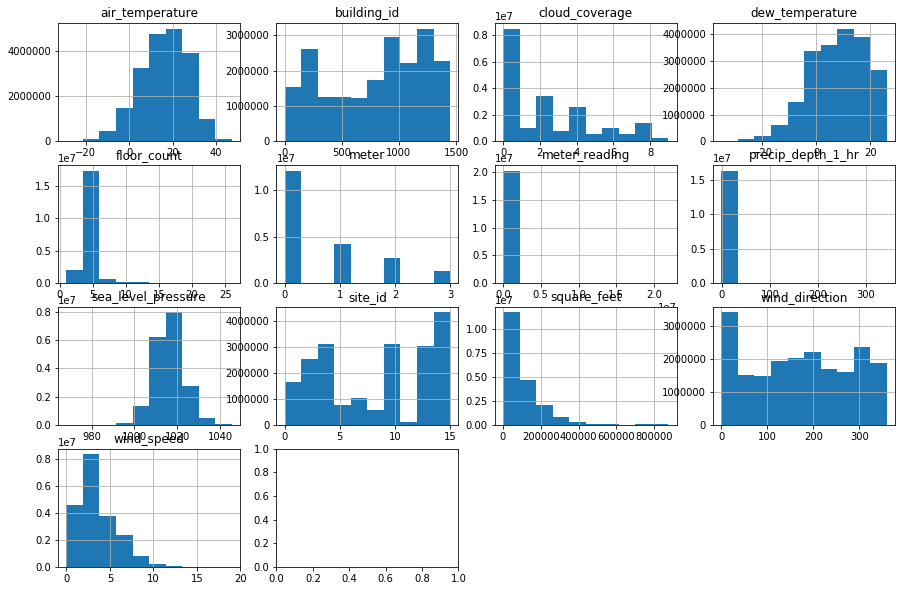

In [23]:
import matplotlib.pyplot as plt
fig = train.hist(figsize=(15, 10),)
[x.title.set_size(10) for x in fig.ravel()]
plt.tight_layout()
plt.show()

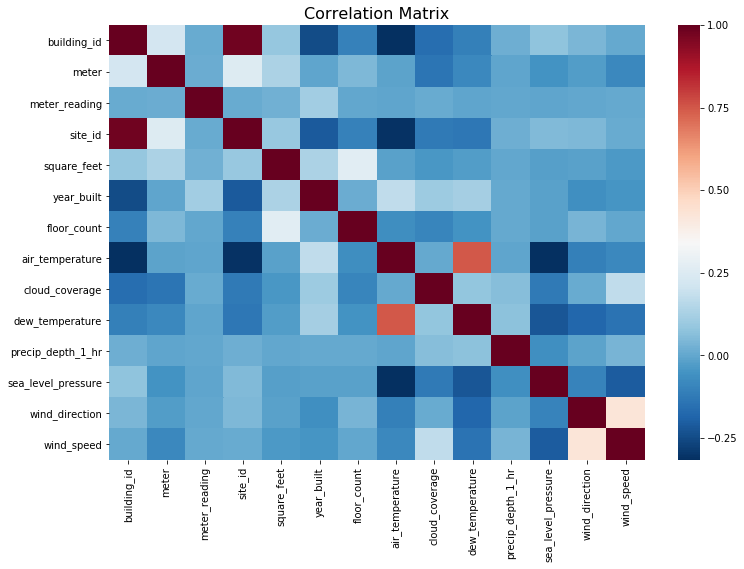

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import seaborn as sns
fig = plt.figure(figsize=(12,8))
train['meter'] = LabelEncoder().fit_transform(train['meter'])

# Separate both dataframes into 
numeric_df = train.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

corr_numeric = numeric_df.corr()
sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [25]:
train[train.columns[1:]].corr()['meter'][:].sort_values(ascending=False)

meter                 1.000000
site_id               0.253875
square_feet           0.132708
floor_count           0.047006
meter_reading         0.017672
precip_depth_1_hr    -0.002283
year_built           -0.003798
air_temperature      -0.011163
wind_direction       -0.026050
sea_level_pressure   -0.052700
dew_temperature      -0.080454
wind_speed           -0.081169
cloud_coverage       -0.139084
Name: meter, dtype: float64

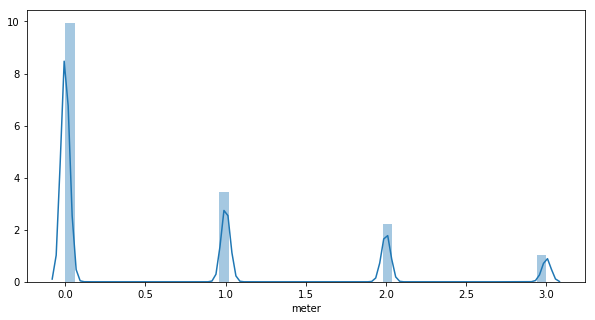

In [26]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.distplot(train['meter'])

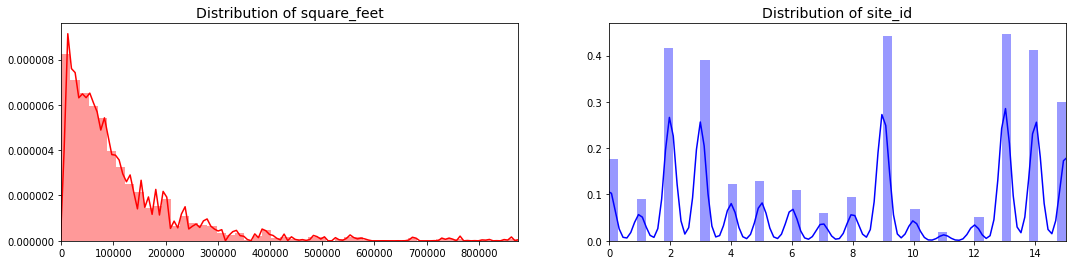

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

square_feet = train['square_feet'].values
site_id = train['site_id'].values

sns.distplot(square_feet, ax=ax[0], color='r')
ax[0].set_title('Distribution of square_feet', fontsize=14)
ax[0].set_xlim([min(square_feet), max(square_feet)])

sns.distplot(site_id, ax=ax[1], color='b')
ax[1].set_title('Distribution of site_id', fontsize=14)
ax[1].set_xlim([min(site_id), max(site_id)])

plt.show()

In [28]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

Text(0, 0.5, 'Frequency')

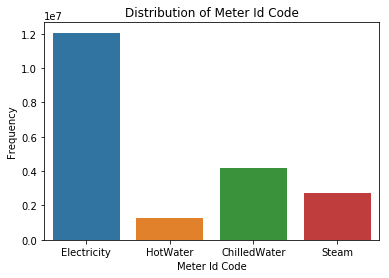

In [29]:
sns.countplot(train['meter'])
plt.title("Distribution of Meter Id Code")
plt.xlabel("Meter Id Code")
plt.ylabel("Frequency")

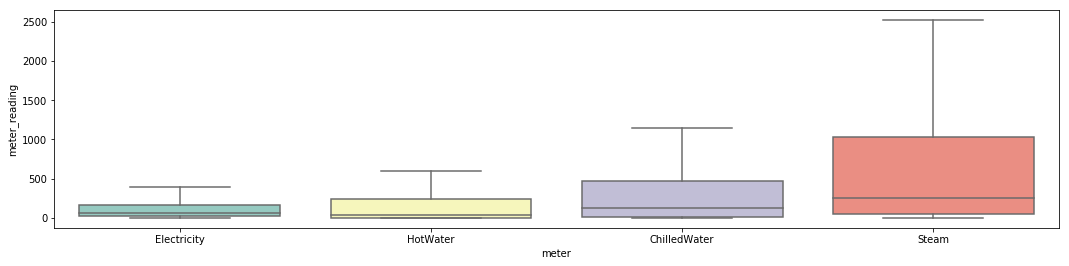

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(18, 4))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False, palette="Set3");

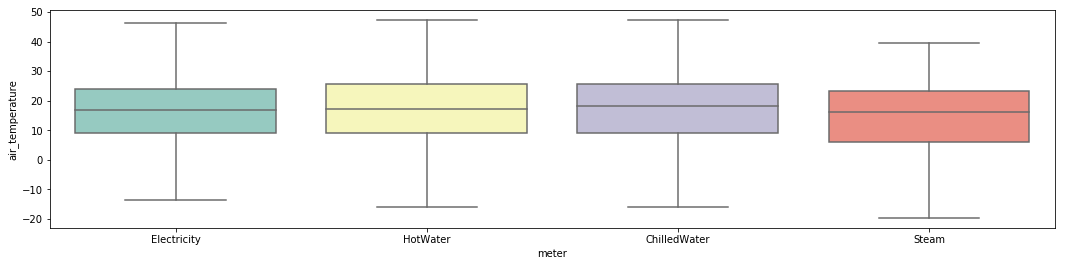

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(18, 4))
sns.boxplot(x='meter', y='air_temperature', data=train,  showfliers=False, palette="Set3");

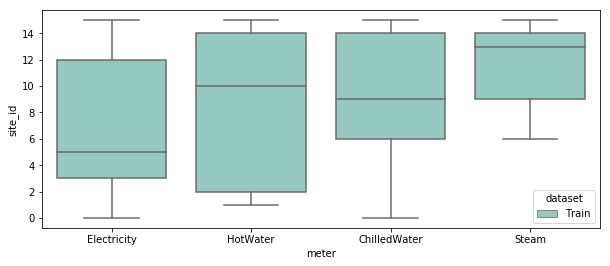

In [32]:
tmp_df = pd.concat([train[['meter', 'site_id']]], ignore_index=True)
tmp_df['dataset'] = 'Train'

fig, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='meter', y='site_id', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df

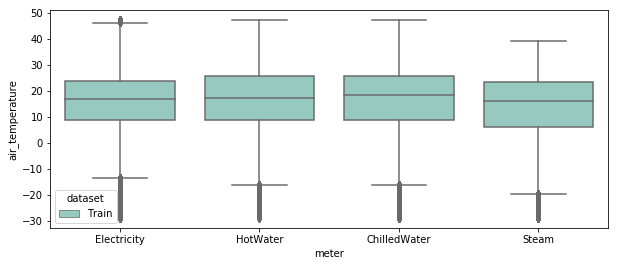

In [33]:
tmp_df = pd.concat([train[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'

fig, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df

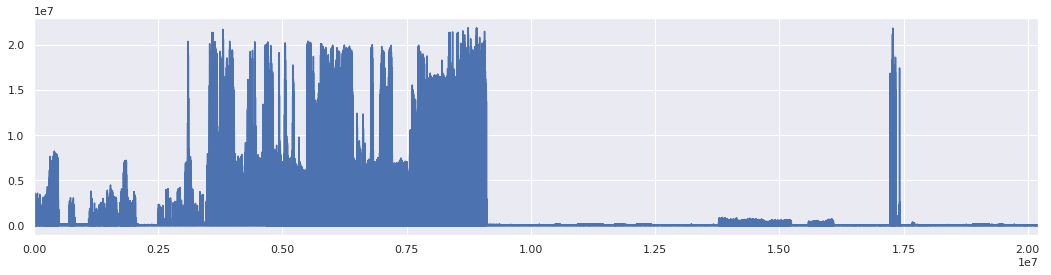

In [34]:
sns.set(rc={'figure.figsize':(18, 4)})
train['meter_reading'].plot();

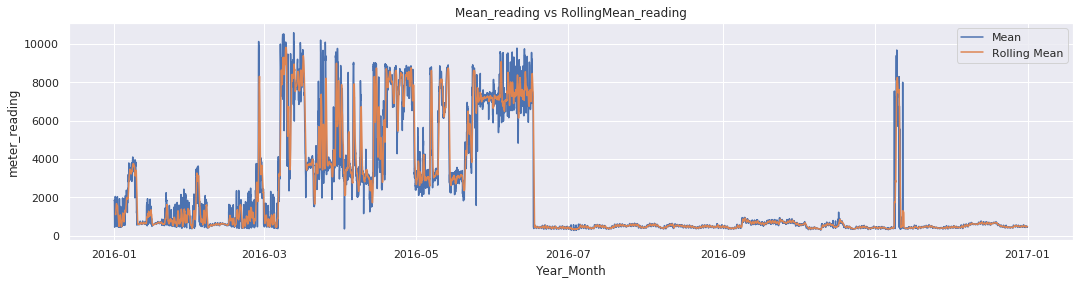

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts=train.groupby(["timestamp"])["meter_reading"].mean().astype('float')
plt.figure(figsize=(18,4))
plt.title('Mean_reading vs RollingMean_reading')
plt.xlabel('Year_Month')
plt.ylabel('meter_reading')
plt.plot(ts,label='Mean');
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.legend();

In [36]:
train['timestamp']= pd.to_datetime(train.timestamp) 
train = train.set_index('timestamp')

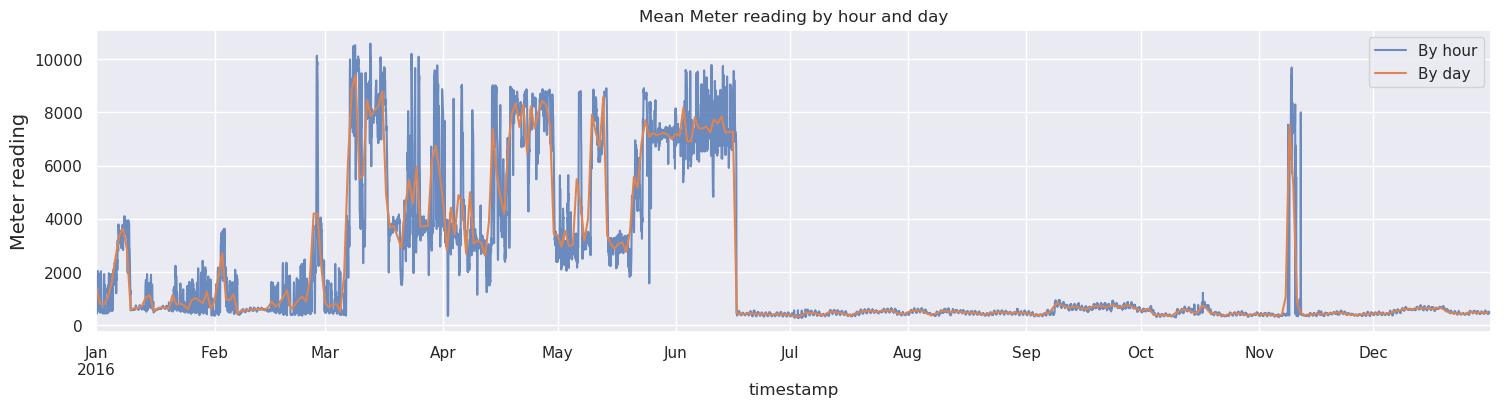

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(18, 4), dpi=100)
train[['meter_reading']].resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['meter_reading']].resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day');
axes.legend();

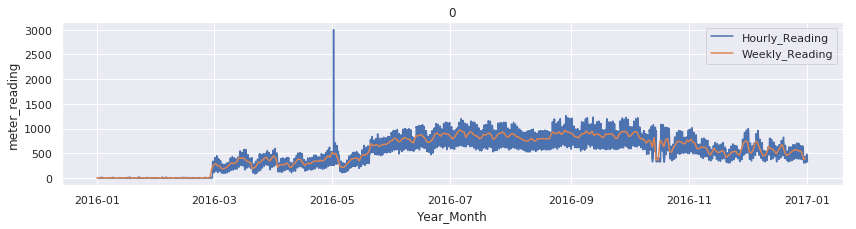

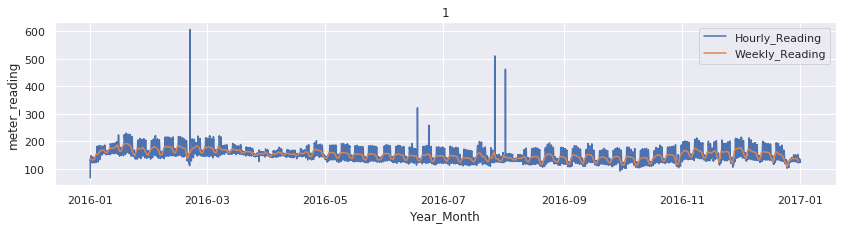

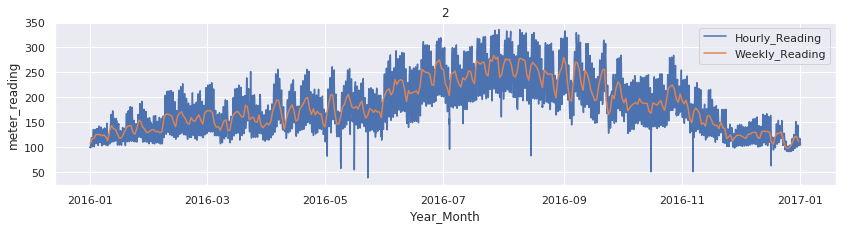

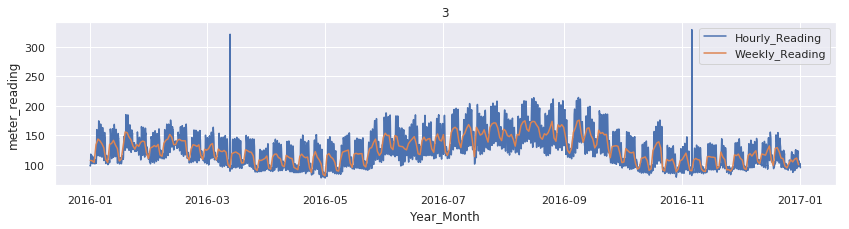

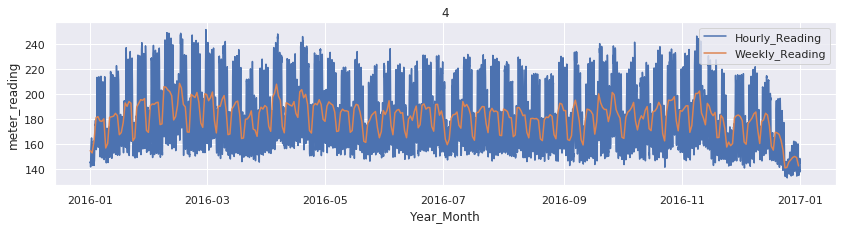

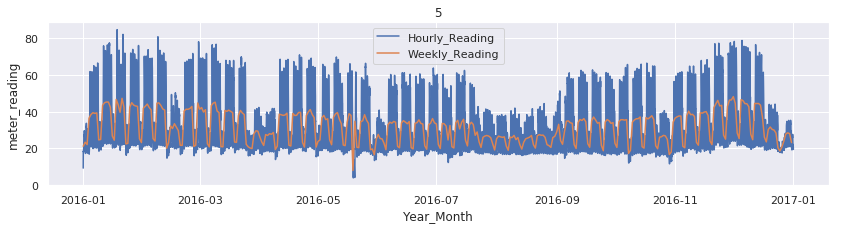

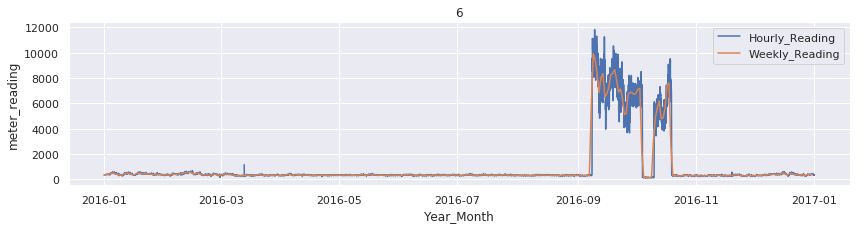

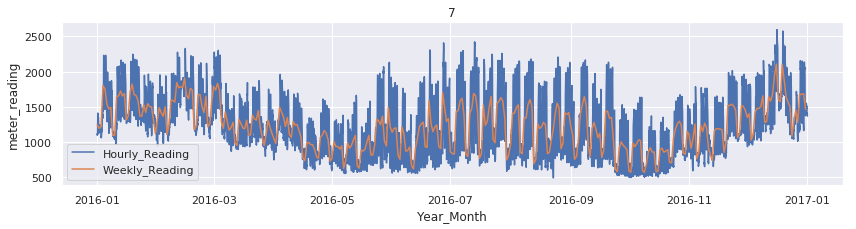

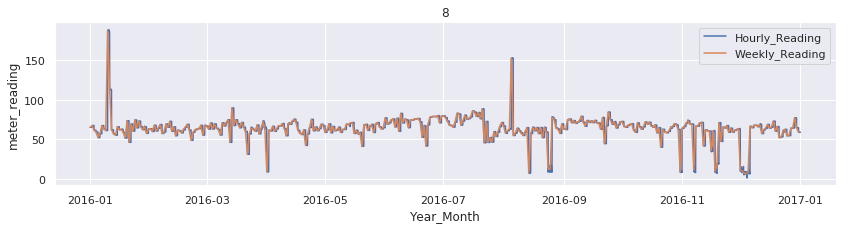

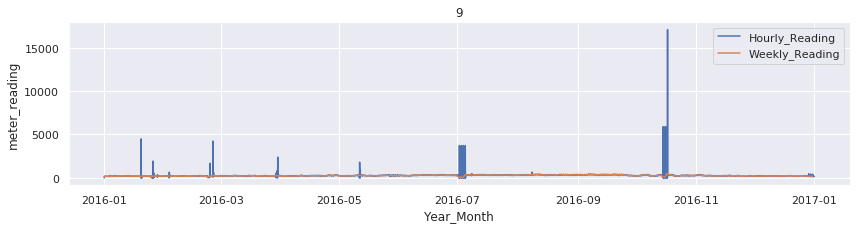

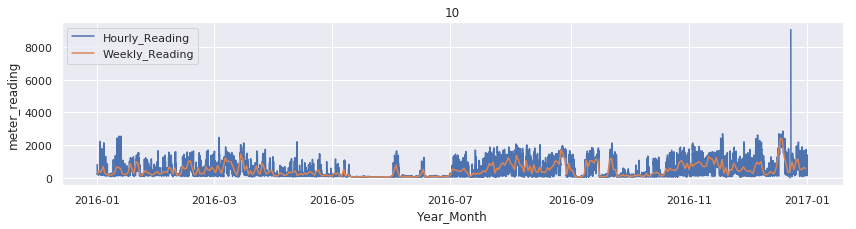

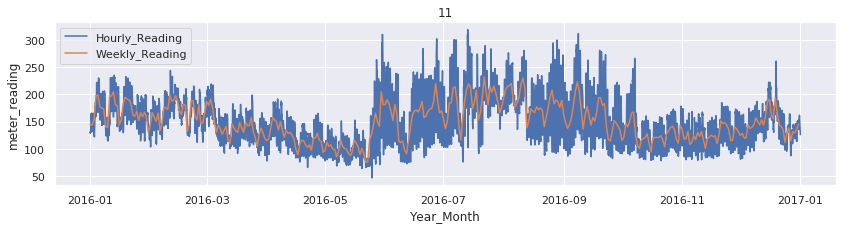

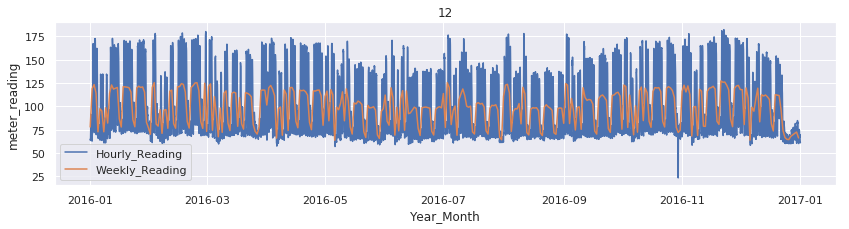

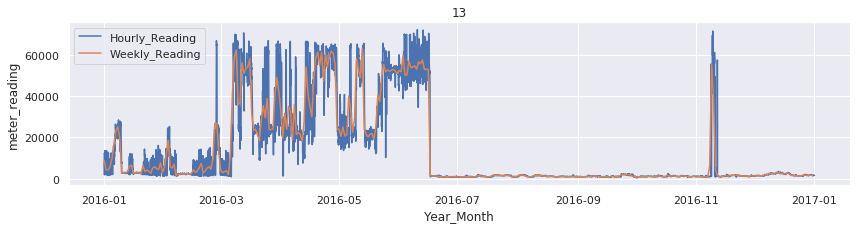

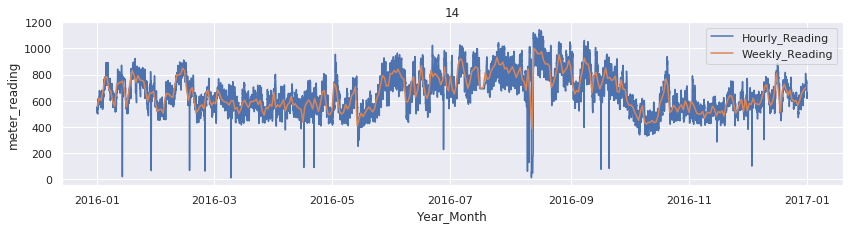

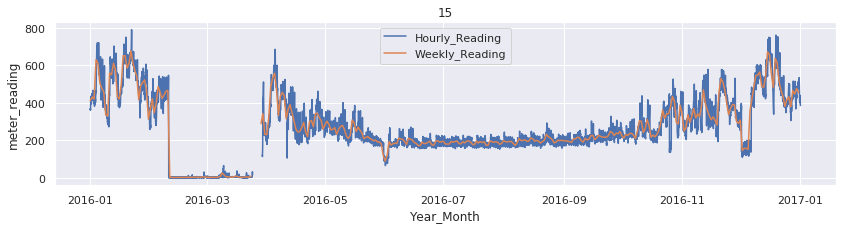

In [38]:
for i in range(train['site_id'].nunique()):
    ts1=train[train['site_id'] == i][['meter_reading']].resample('H').mean().astype('float')
    ts2=train[train['site_id'] == i][['meter_reading']].resample('D').mean().astype('float')
    plt.figure(figsize=(14,3))
    plt.title("Site id")
    plt.title(i)
    plt.xlabel('Year_Month')
    plt.ylabel('meter_reading')
    plt.plot(ts1,label='Hourly_Reading');
    plt.plot(ts2,label='Weekly_Reading');
    plt.legend(); 

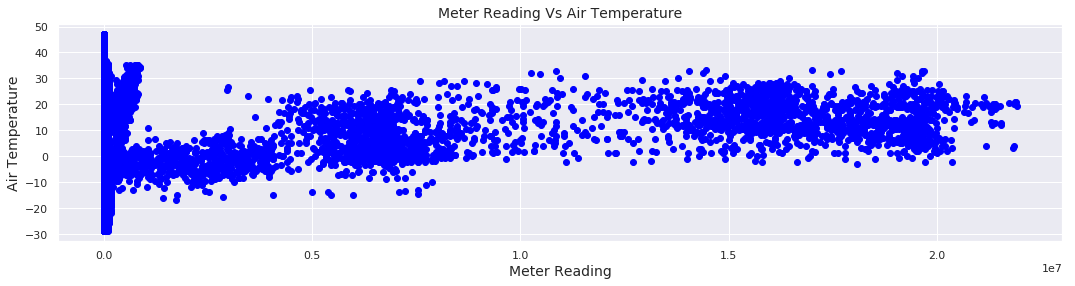

In [39]:
plt.scatter(train['meter_reading'], train['air_temperature'], color='blue')
plt.title('Meter Reading Vs Air Temperature', fontsize=14)
plt.xlabel('Meter Reading', fontsize=14)
plt.ylabel('Air Temperature', fontsize=14)
plt.grid(True)
plt.show()

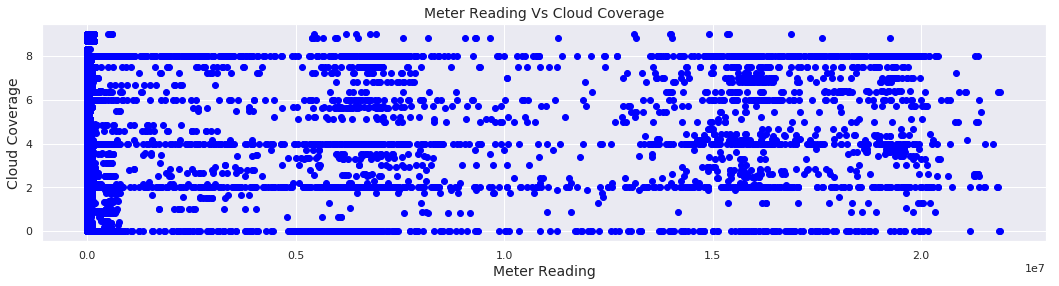

In [40]:
plt.scatter(train['meter_reading'], train['cloud_coverage'], color='blue')
plt.title('Meter Reading Vs Cloud Coverage', fontsize=14)
plt.xlabel('Meter Reading', fontsize=14)
plt.ylabel('Cloud Coverage', fontsize=14)
plt.grid(True)
plt.show()

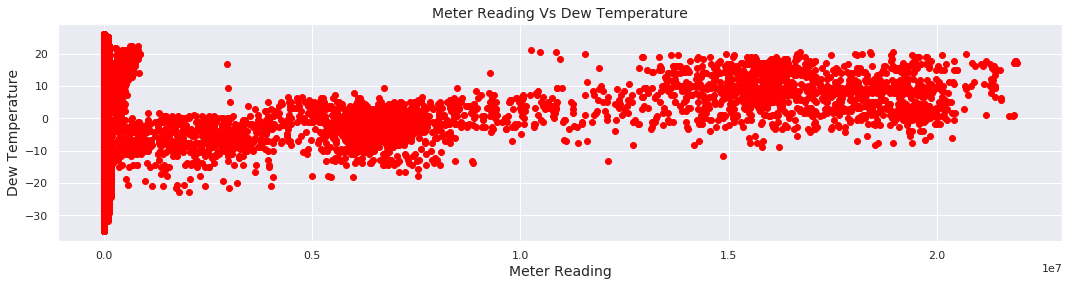

In [41]:
plt.scatter(train['meter_reading'], train['dew_temperature'], color='red')
plt.title('Meter Reading Vs Dew Temperature', fontsize=14)
plt.xlabel('Meter Reading', fontsize=14)
plt.ylabel('Dew Temperature', fontsize=14)
plt.grid(True)
plt.show()